# Model evaluation: mole classification on the HAM10000 dataset.

## The models evaluated on this notebook were trained on the resized (128x128) HAM10000 dataset without **hair removal**, **segmentation**  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from scipy import stats

import itertools

import os
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#model directories
frozen_dir = "/content/drive/MyDrive/Project 36100 - Andrea, Monika, Yamuna/Assignment Stage 2/Frozen_model/" #model with ImageNet weights frozen, with several added layers.
fine_tuned_dir = "/content/drive/MyDrive/Project 36100 - Andrea, Monika, Yamuna/Assignment Stage 2/Fine_tuned_model/" #fine-tuned model

## I. Dataset without hair removal and lesion segmentation

In [ ]:
#modify the path depending on the model you plan to evaluate
X = np.load('/content/drive/MyDrive/Project 36100 - Andrea, Monika, Yamuna/Assignment Stage 2/X_NO_dullrazor_NO_segmentation_128.npy')/255 #forgot to normalize
y = np.load('/content/drive/MyDrive/Project 36100 - Andrea, Monika, Yamuna/Assignment Stage 2/y_NO_dullrazor_NO_segmentation_128.npy')

In [ ]:
def prepare_data(X, y):
    def prepare_labels(labels):
        """Convert string labels to one-hot encoding"""
        #create and fit label encoder
        label_encoder = LabelEncoder()
        numeric_labels = label_encoder.fit_transform(labels)

        #save label encoder classes so we can use them later for interpretation
        label_mapping = dict(zip(label_encoder.classes_,
                                range(len(label_encoder.classes_))))
        #one-hot encoding the numeric-encoded classes
        one_hot_labels = tf.keras.utils.to_categorical(numeric_labels)

        #Print mapping for verification
        print("Label mapping:")
        for label, idx in label_mapping.items():
            print(f"{label}: {idx}")

        return one_hot_labels, label_encoder

    y_encoded, label_encoder = prepare_labels(y)

    def normalize_images_imagenet(X):
        """
        Normalize images using ImageNet mean and std
        """
        #ImageNet normalization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        for i in range(3):
            X[:,:,:,i] = (X[:,:,:,i] - mean[i]) / std[i]

        return X

    X = normalize_images_imagenet(X)

    ##---Data splitting: we want a 75, 20, 5 train/test/validation split
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y_encoded,
        test_size=0.20,
        random_state=42, #same seed we used in the training
        stratify=y_encoded
    )

    #Then split remaining data into train and validation (val is 5% of total)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val,
        test_size=0.0625,  #0.05/0.80 to get 5% of total data
        random_state=42,#again same seed we used for training
        stratify=y_train_val
    )
    return X_train, X_val, X_test, y_train, y_val, y_test, label_encoder

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test, label_encoder = prepare_data(X, y)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

Label mapping:
akiec: 0
bcc: 1
bkl: 2
df: 3
mel: 4
nv: 5
vasc: 6
(7507, 128, 128, 3)
(501, 128, 128, 3)
(2002, 128, 128, 3)
(7507, 7)
(501, 7)
(2002, 7)


### I.1. Load models - No hair removal, No segmentation

In [ ]:
frozen_model_path = frozen_dir + 'densenet201_ph1_128_no_dullrazor_no_segmentation.keras'
frozen_model = load_model(frozen_model_path)

fine_tuned_model_path = fine_tuned_dir + 'densenet201_ph2_128_no_dullrazor_no_segmentation.keras'
fine_tuned_model = load_model(fine_tuned_model_path)

## I.2. Plot confusion - No hair removal, No segmentation

In [ ]:
def plot_confusion_matrix(y_true, y_pred, label_encoder, title='Confusion Matrix'):
    """
    Plot confusion matrix using matplotlib with class names from label encoder.
    """
    # Convert one-hot encoded labels back to class indices
    if len(y_true.shape) > 1:  # if one-hot encoded
        y_true = np.argmax(y_true, axis=1)
    if len(y_pred.shape) > 1:  # if one-hot encoded
        y_pred = np.argmax(y_pred, axis=1)

    classes = label_encoder.classes_
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    # Add tick marks and labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)

    # Add text annotations
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    return cm

### I.2.1 Confusion matrix on the test set

63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step


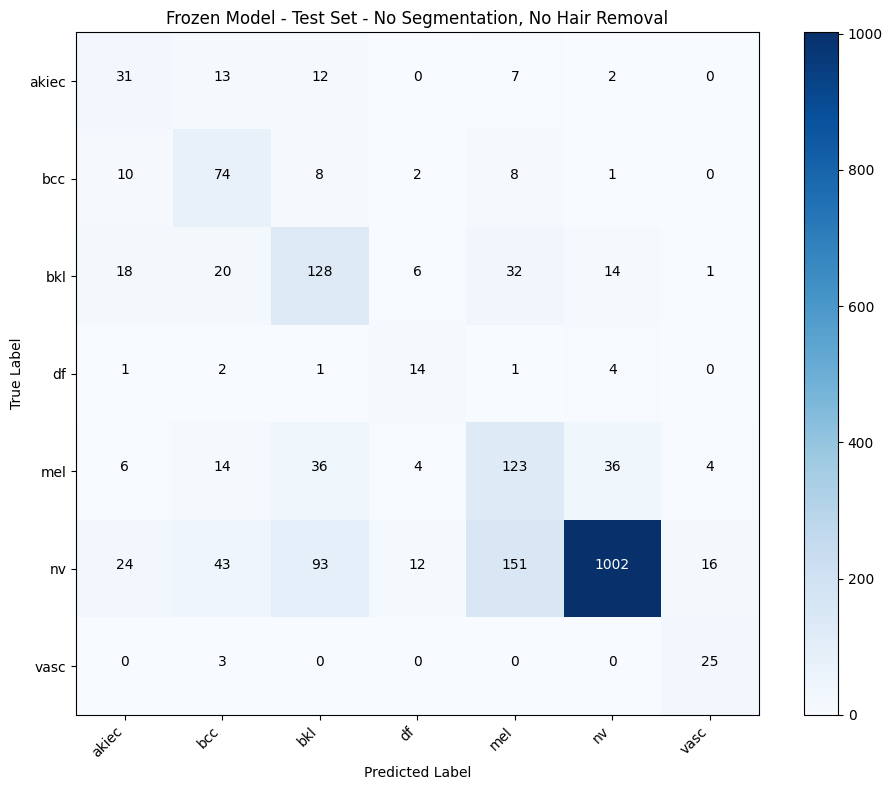

In [ ]:
plot_confusion_matrix(y_test, frozen_model.predict(X_test), label_encoder, title='Frozen Model - Test Set - No Segmentation, No Hair Removal');

63/63 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step


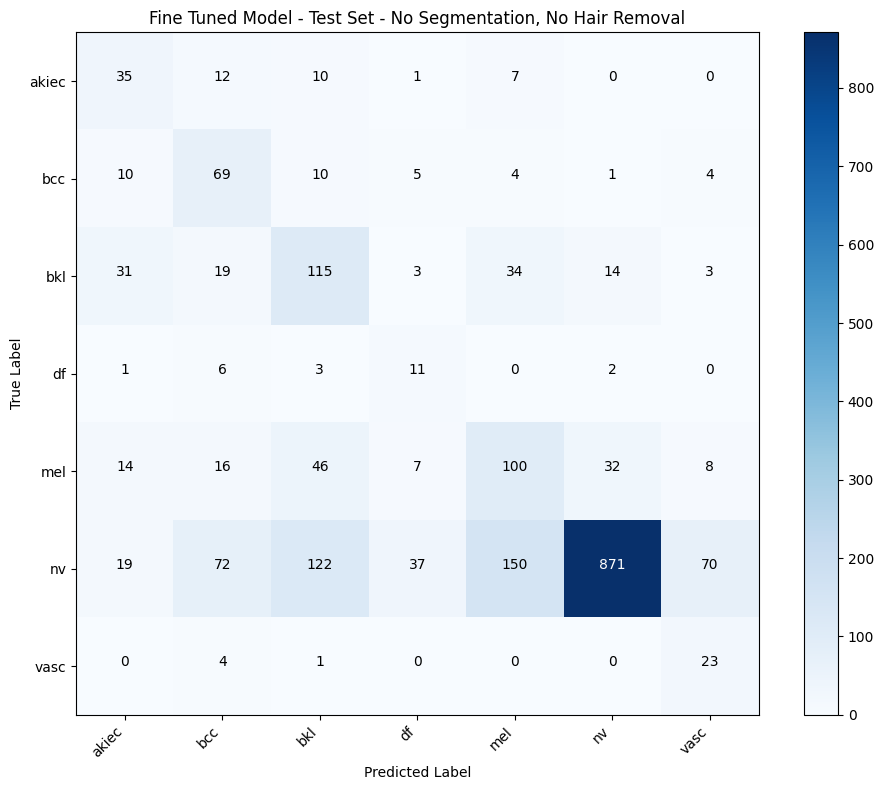

In [ ]:
plot_confusion_matrix(y_test, fine_tuned_model.predict(X_test), label_encoder, title='Fine Tuned Model - Test Set - No Segmentation, No Hair Removal');

### I.2.2 Confusion Matrix on the validation set

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


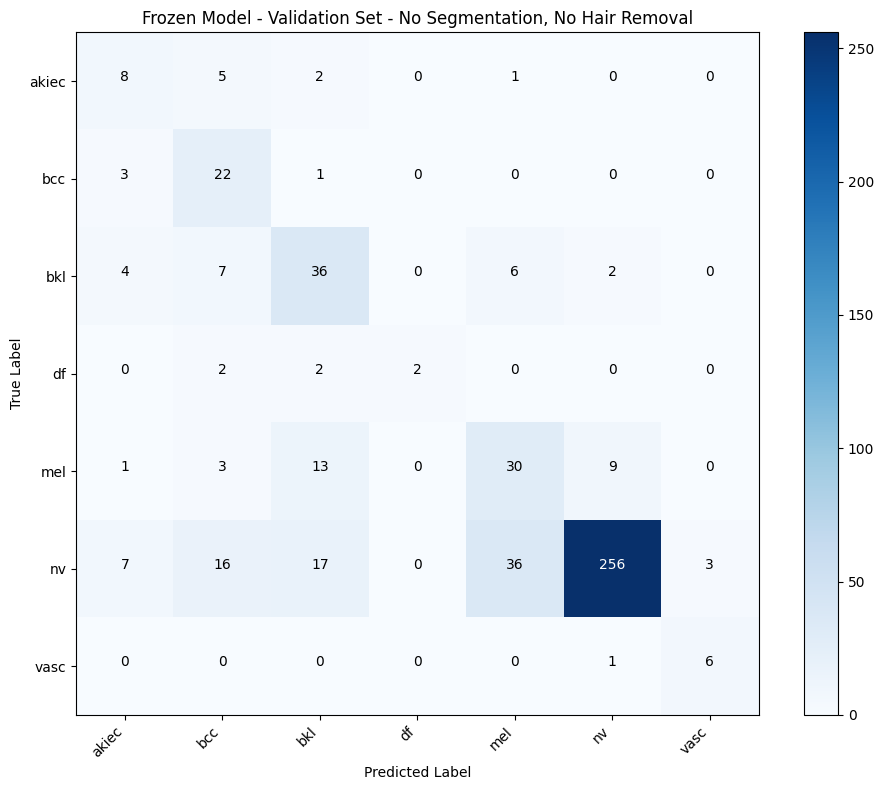

In [ ]:
plot_confusion_matrix(y_val, frozen_model.predict(X_val), label_encoder, title='Frozen Model - Validation Set - No Segmentation, No Hair Removal');

16/16 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step


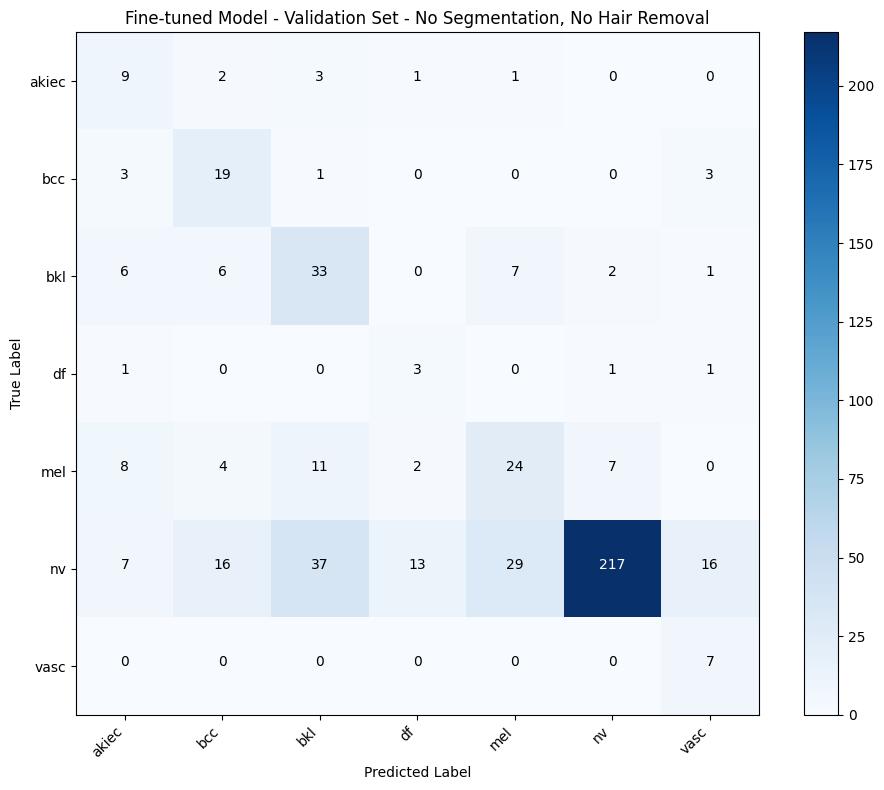

In [ ]:
plot_confusion_matrix(y_val, fine_tuned_model.predict(X_val), label_encoder, title='Fine-tuned Model - Validation Set - No Segmentation, No Hair Removal');

## I.3 ROC Curve and AUC metrics

### I.3.1 ROC curves and AUC - Test Set

In [ ]:
def plot_roc_curves(y_true, y_pred_proba, label_encoder, title):
    """
    Plot ROC curves for each class using class names from label encoder.
    """
    classes = label_encoder.classes_
    n_classes = len(classes)

    plt.figure(figsize=(10, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

    #Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i, color in zip(range(n_classes), colors):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=color,
                label=f'ROC curve ({classes[i]}) (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

    return roc_auc

63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step


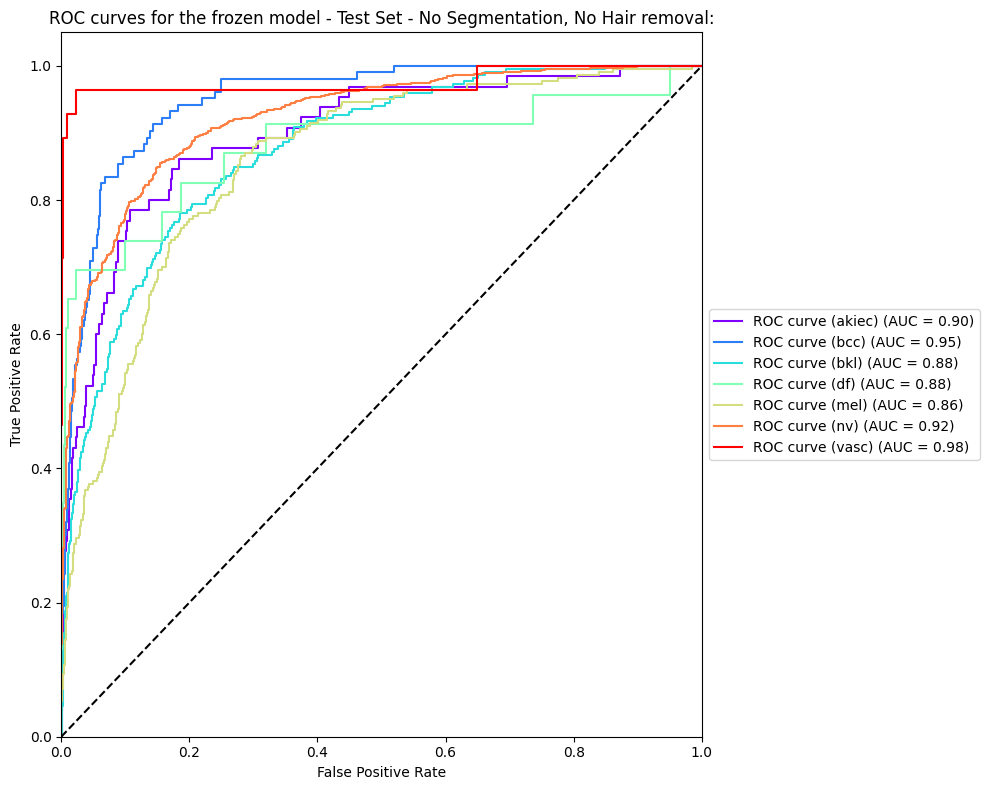

In [ ]:
#AUC value for the frozen model, on the Test Set - No Segmentation, No Hair removal
plot_roc_curves(y_test, frozen_model.predict(X_test), label_encoder, "ROC curves for the frozen model - Test Set - No Segmentation, No Hair removal:");

63/63 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step


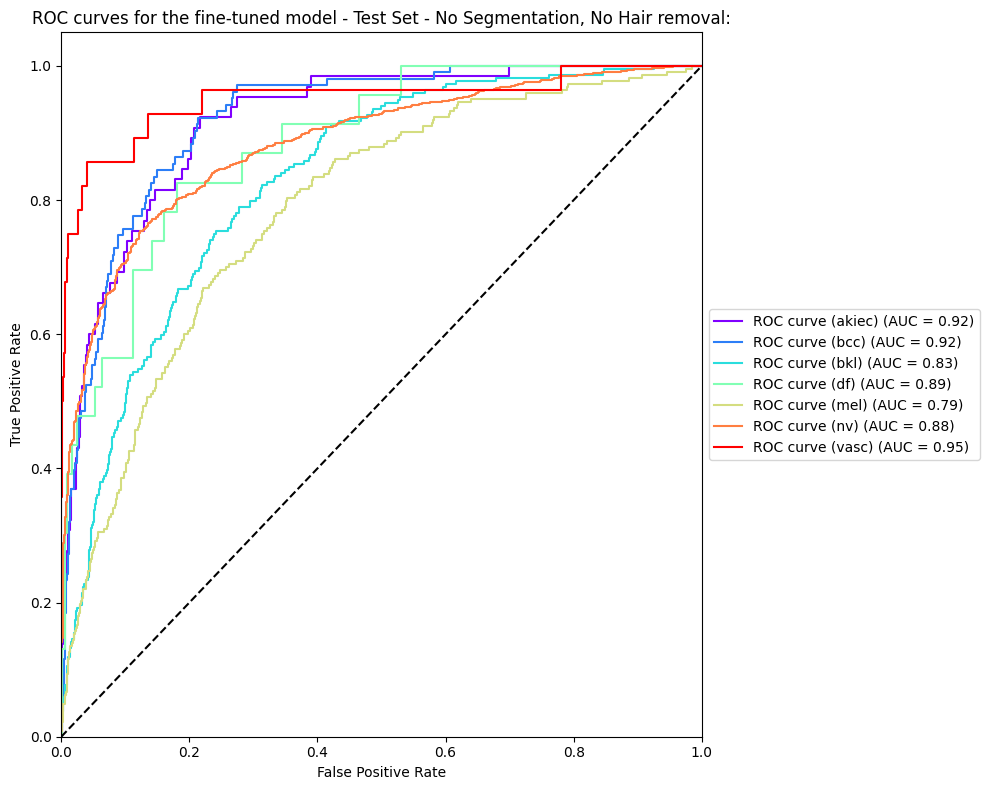

In [ ]:
#Plot the ROC curves with AUC values for the fine tuned model
plot_roc_curves(y_test, fine_tuned_model.predict(X_test), label_encoder, "ROC curves for the fine-tuned model - Test Set - No Segmentation, No Hair removal:");

### I.3.2 ROC curves and AUC on the validation set

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


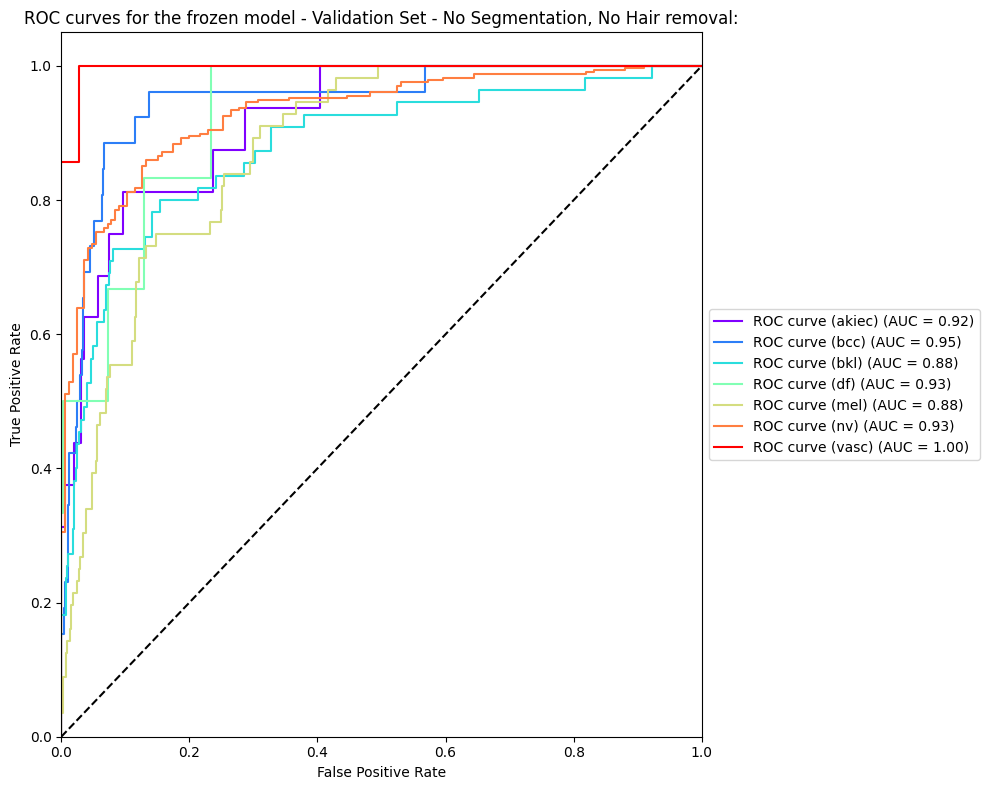

In [ ]:
#AUC value for the frozen model, on the Validation Set - No Segmentation, No Hair removal
plot_roc_curves(y_val, frozen_model.predict(X_val), label_encoder, "ROC curves for the frozen model - Validation Set - No Segmentation, No Hair removal:");

16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


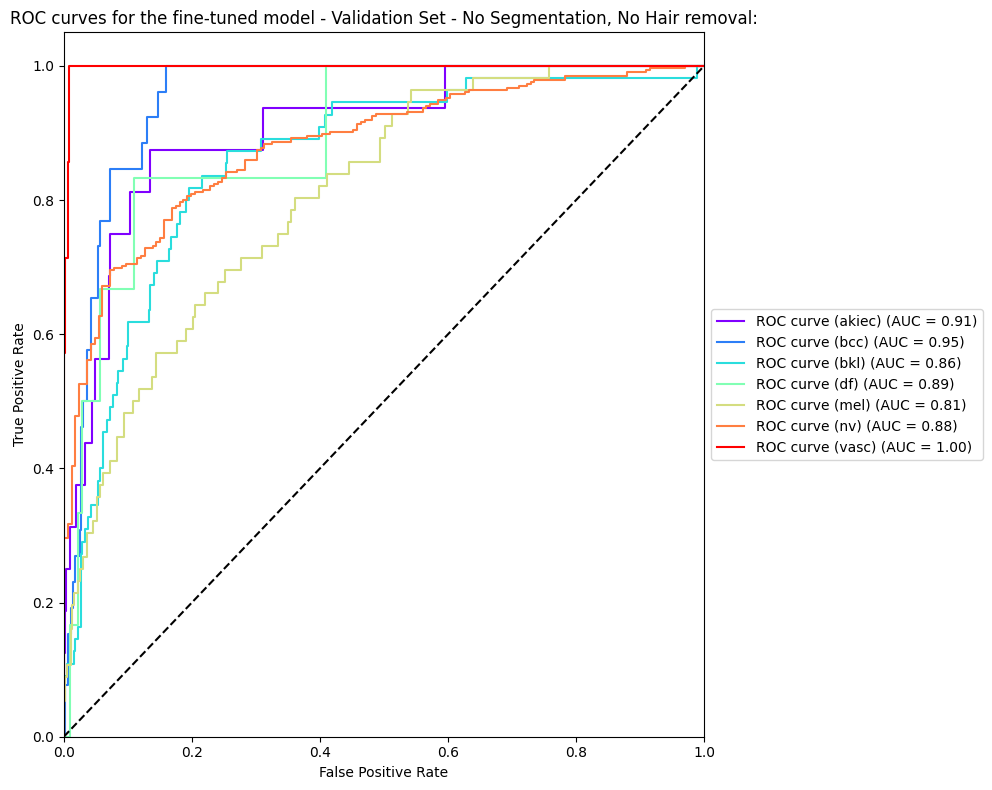

In [ ]:
#Plot the ROC curves with AUC values for the fine tuned model, on the Validation Set
plot_roc_curves(y_val, fine_tuned_model.predict(X_val), label_encoder, "ROC curves for the fine-tuned model - Validation Set - No Segmentation, No Hair removal:");

## I.4 Precision and Recall

### I.4.1 Precision and Recall - Test Set

In [ ]:
def plot_precision_recall_curves(y_true, y_pred_proba, label_encoder, title):
    """
    Plot Precision-Recall curves for each class.
    """
    classes = label_encoder.classes_
    n_classes = len(classes)

    plt.figure(figsize=(10, 8))
    colors = plt.cm.rainbow(np.linspace(0, 1, n_classes))

    for i, color in zip(range(n_classes), colors):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred_proba[:, i])
        avg_precision = np.mean(precision)
        plt.plot(recall, precision, color=color,
                label=f'{classes[i]} (AP = {avg_precision:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()

63/63 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step


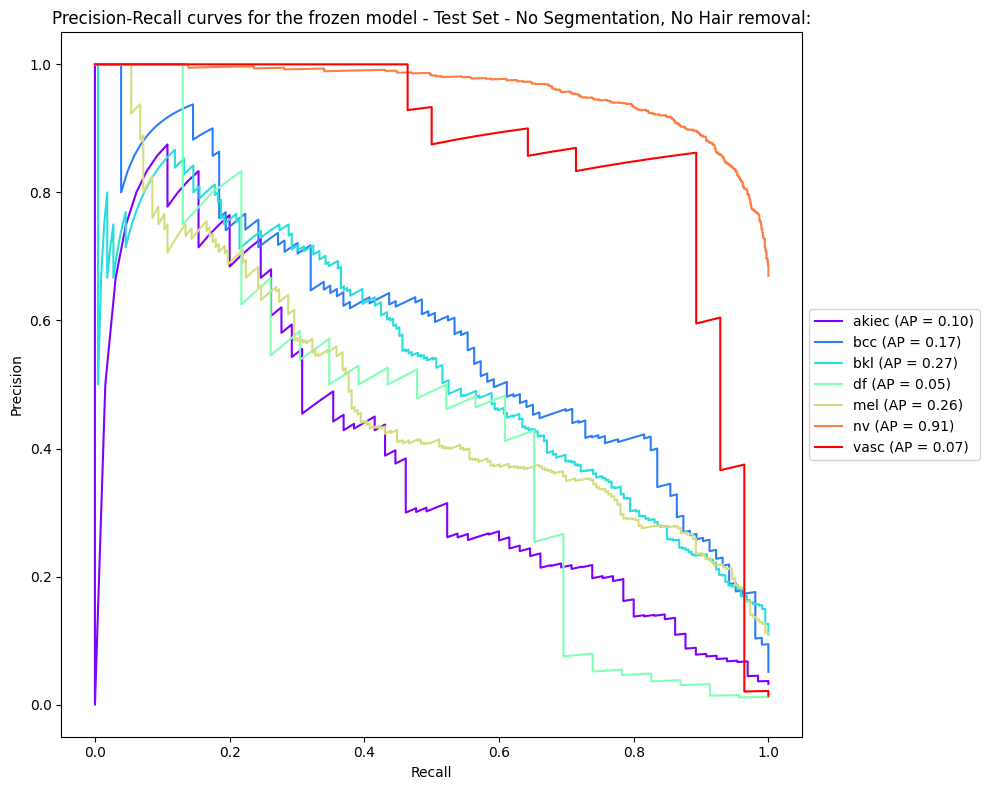

In [ ]:
#compute Precision and recall for Frozen model on the Test Set
plot_precision_recall_curves(y_test, frozen_model.predict(X_test), label_encoder, "Precision-Recall curves for the frozen model - Test Set - No Segmentation, No Hair removal:");

63/63 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step


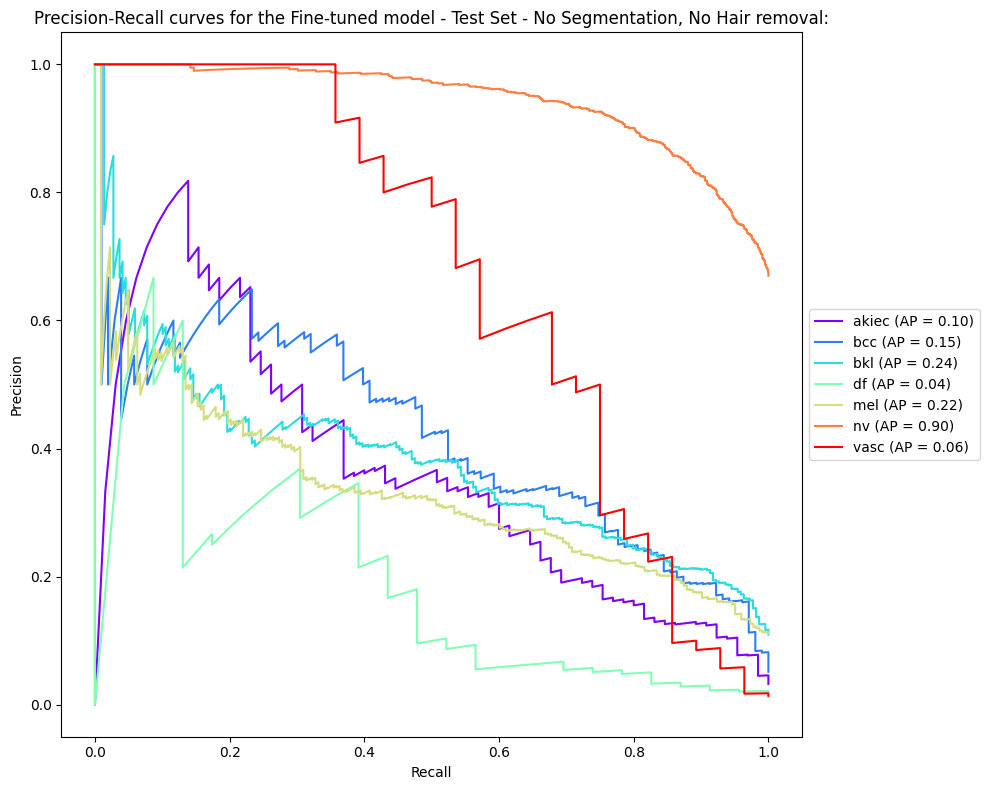

In [ ]:
#compute Precision and recall for Fine-tuned model on the Test Set
plot_precision_recall_curves(y_test, fine_tuned_model.predict(X_test), label_encoder, "Precision-Recall curves for the Fine-tuned model - Test Set - No Segmentation, No Hair removal:");

### I.4.2 Precision and Recall on the Validation Set

16/16 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step


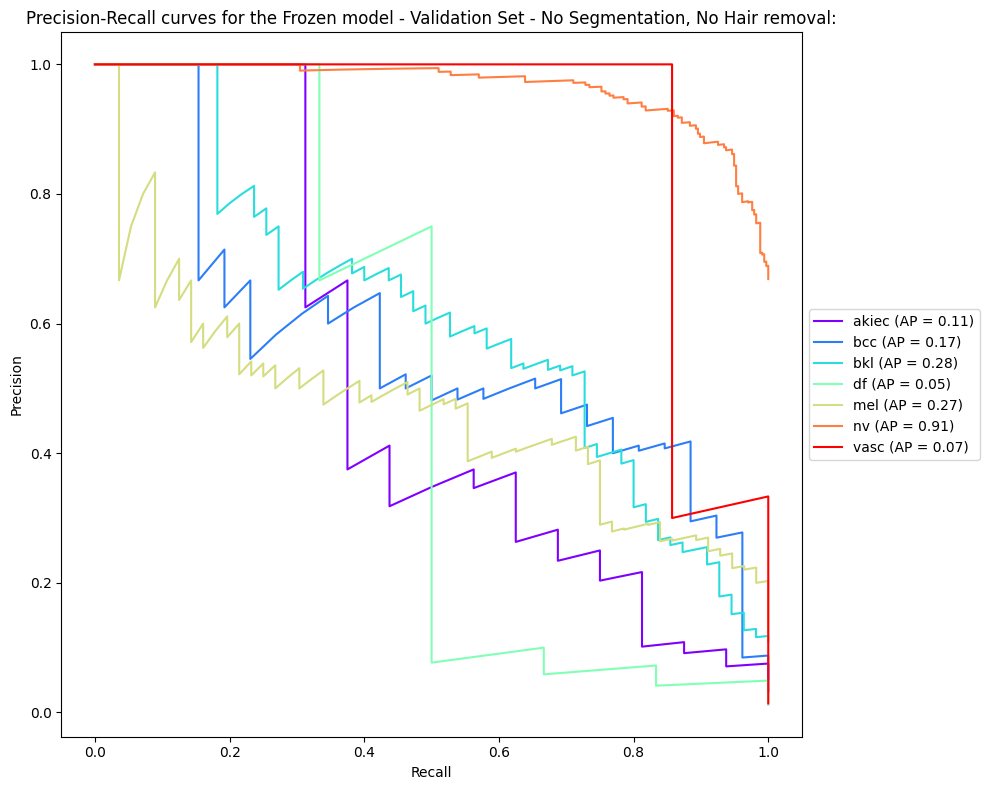

In [ ]:
#compute Precision and recall for Frozen model on the Validation Set
plot_precision_recall_curves(y_val, frozen_model.predict(X_val), label_encoder, "Precision-Recall curves for the Frozen model - Validation Set - No Segmentation, No Hair removal:");

16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step


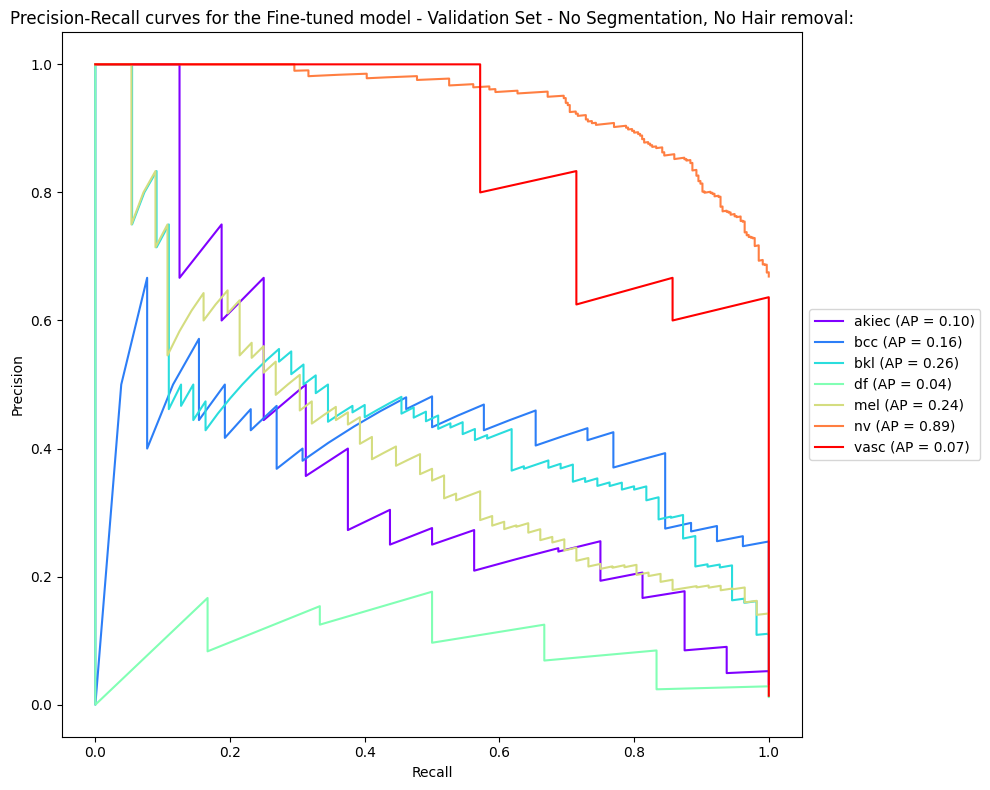

In [ ]:
#compute Precision and recall for Fine-tuned model on the Validation Set
plot_precision_recall_curves(y_val, fine_tuned_model.predict(X_val), label_encoder, "Precision-Recall curves for the Fine-tuned model - Validation Set - No Segmentation, No Hair removal:");